In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import spearmanr
from loader import load_models, MODEL_ORDER, MODEL_COLORS

# Only load columns needed for model comparison
usecols = ["game_id", "player_id", "turn", "turn_progress", "is_winner", "predicted_win_probability"]
models = load_models(usecols=usecols)

# Exclude naive for pairwise comparison
models.pop("naive", None)

model_names = [m for m in MODEL_ORDER if m in models]
print(f"\nModels found: {model_names}")

Loaded naive: 1,875,256 rows
Loaded score: 1,875,256 rows
Loaded baseline: 1,875,256 rows
Loaded xgboost: 1,875,256 rows
Loaded mlp: 1,875,256 rows
Loaded grouped_mlp: 1,875,256 rows
Loaded interaction_mlp: 1,875,256 rows
Loaded attention_mlp: 1,875,256 rows

Models found: ['score', 'baseline', 'xgboost', 'mlp', 'grouped_mlp', 'interaction_mlp', 'attention_mlp']


## 2a. Model Disagreement Scatter
Pairwise scatter plots of predicted probabilities between models.  
Points near the diagonal indicate agreement; off-diagonal points reveal where models disagree.

Merged rows: 1,875,256


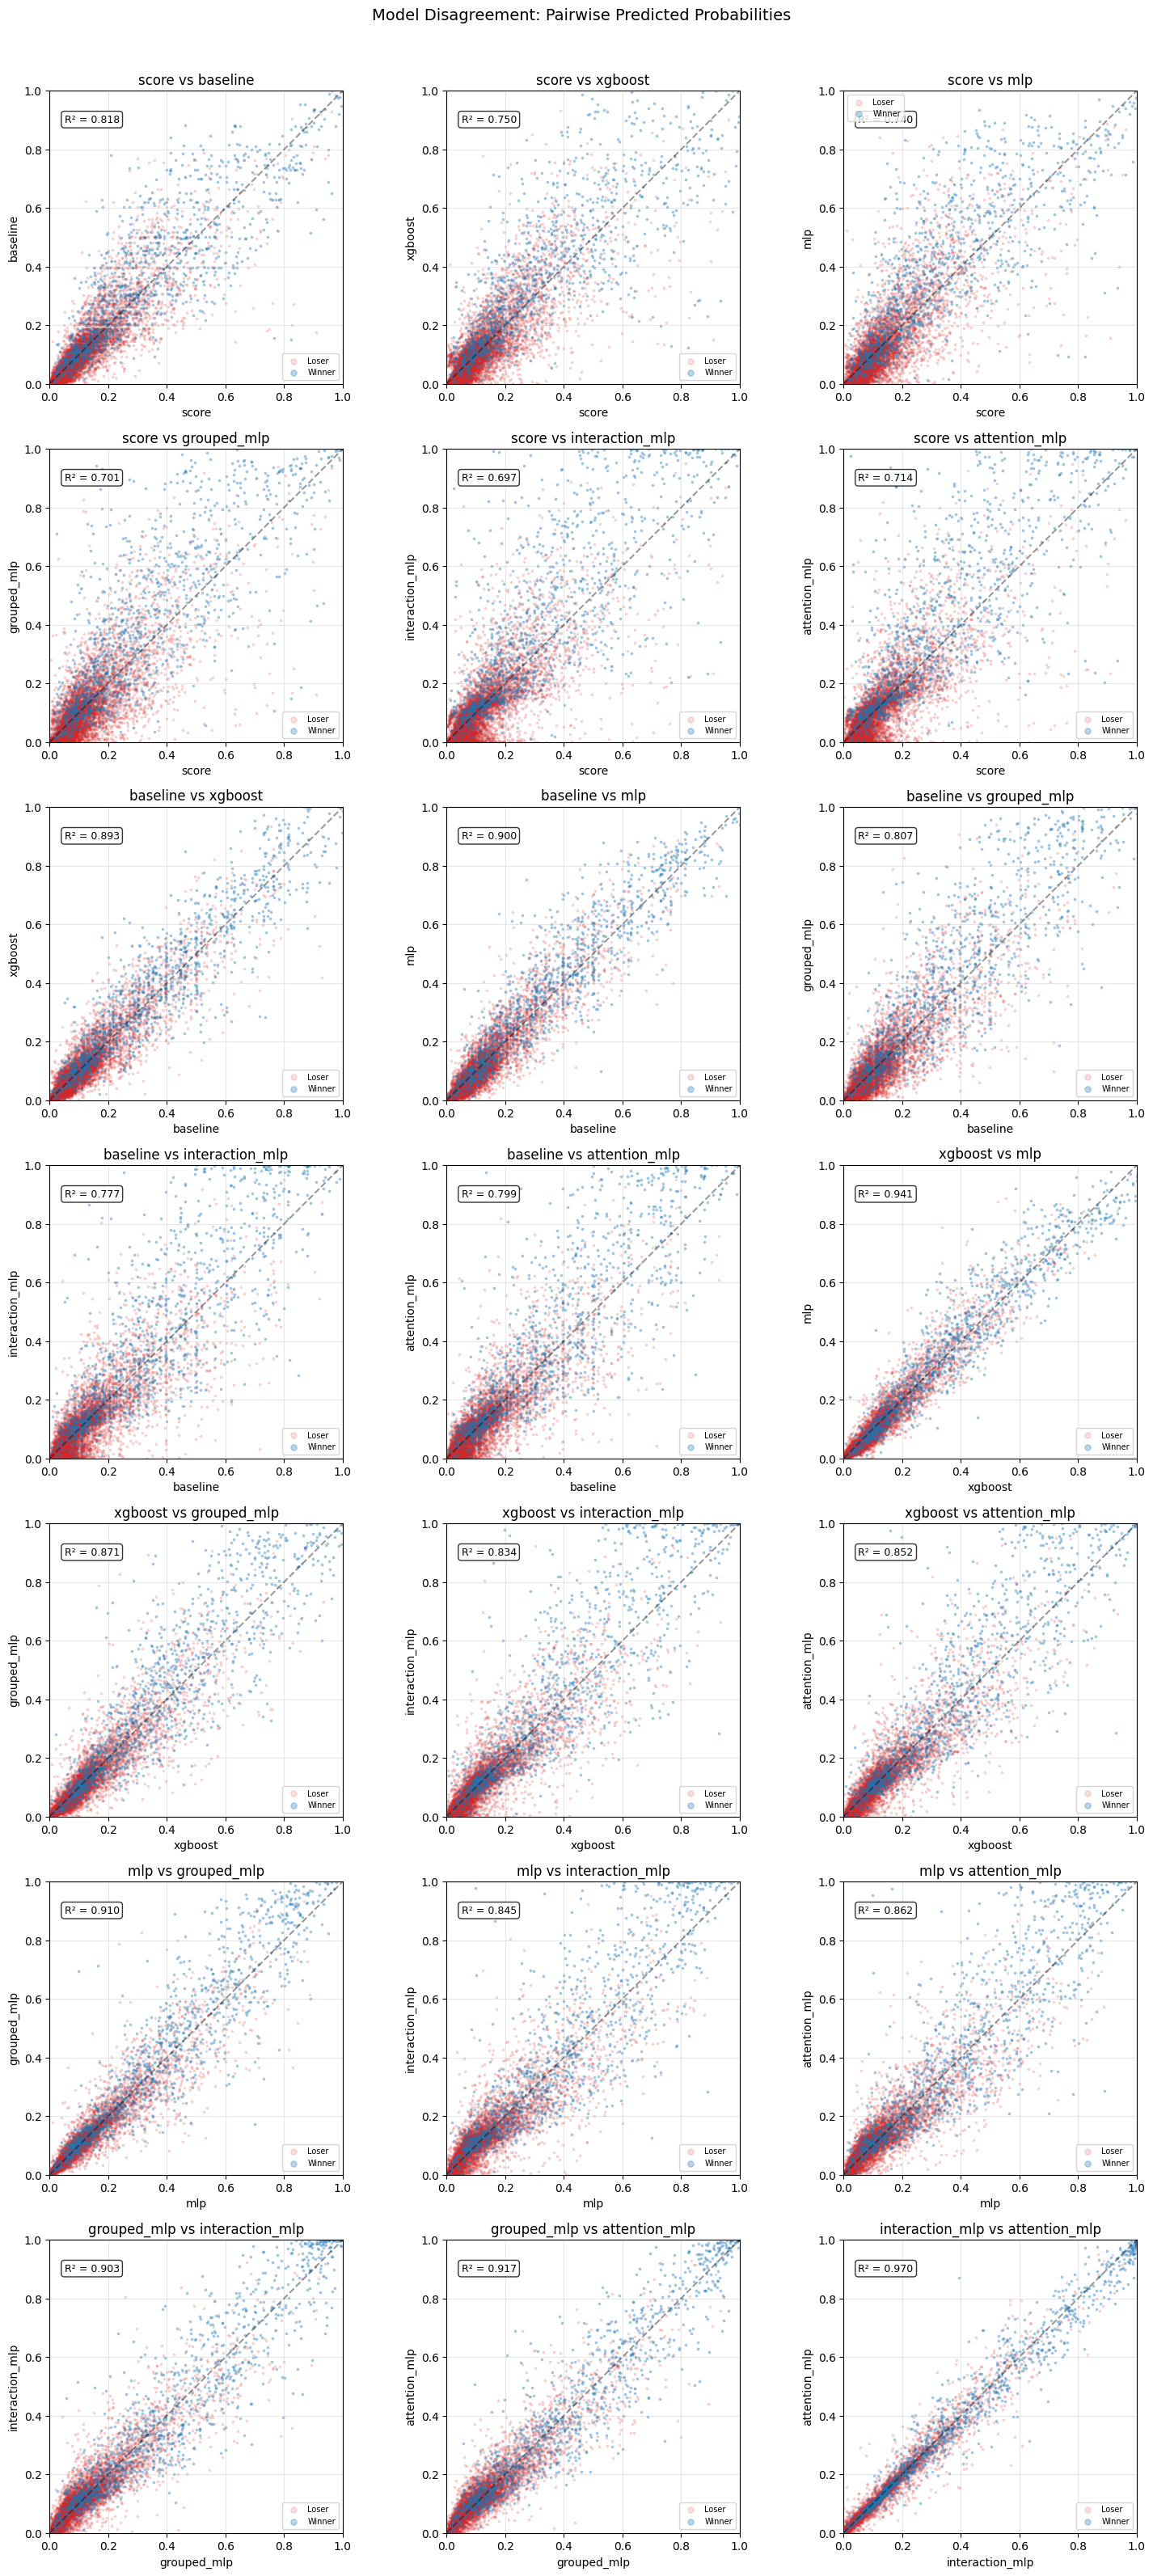

In [2]:
# Build a merged DataFrame with predictions from all models
# Use the first model's metadata columns and merge predictions by shared keys
ref_name = model_names[0]
ref_df = models[ref_name][["game_id", "player_id", "turn", "is_winner", "predicted_win_probability"]].copy()
ref_df = ref_df.rename(columns={"predicted_win_probability": f"pred_{ref_name}"})

merged = ref_df
for name in model_names[1:]:
    other = models[name][["game_id", "player_id", "turn", "predicted_win_probability"]].copy()
    other = other.rename(columns={"predicted_win_probability": f"pred_{name}"})
    merged = merged.merge(other, on=["game_id", "player_id", "turn"], how="inner")

print(f"Merged rows: {len(merged):,}")

# Subsample for plotting
sample = merged.sample(n=min(10_000, len(merged)), random_state=42)

pairs = list(combinations(model_names, 2))
n_pairs = len(pairs)
cols = min(3, n_pairs)
rows = (n_pairs + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), squeeze=False)

for idx, (m1, m2) in enumerate(pairs):
    ax = axes[idx // cols][idx % cols]
    winners = sample["is_winner"] == 1
    ax.scatter(sample.loc[~winners, f"pred_{m1}"], sample.loc[~winners, f"pred_{m2}"],
               alpha=0.15, s=3, c="tab:red", label="Loser")
    ax.scatter(sample.loc[winners, f"pred_{m1}"], sample.loc[winners, f"pred_{m2}"],
               alpha=0.3, s=3, c="tab:blue", label="Winner")
    ax.plot([0, 1], [0, 1], "k--", alpha=0.4)

    # Compute R² on full data (not sample)
    r = np.corrcoef(merged[f"pred_{m1}"], merged[f"pred_{m2}"])[0, 1]
    r2 = r ** 2
    ax.text(0.05, 0.92, f"R² = {r2:.3f}", transform=ax.transAxes,
            fontsize=9, verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    ax.set_xlabel(m1)
    ax.set_ylabel(m2)
    ax.set_title(f"{m1} vs {m2}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7, markerscale=3)

for idx in range(n_pairs, rows * cols):
    axes[idx // cols][idx % cols].set_visible(False)

fig.suptitle("Model Disagreement: Pairwise Predicted Probabilities", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 2b. Within-Game Rank Agreement
For each (game, turn), rank the players by predicted probability per model.  
Spearman correlation measures how much models agree on the ranking.

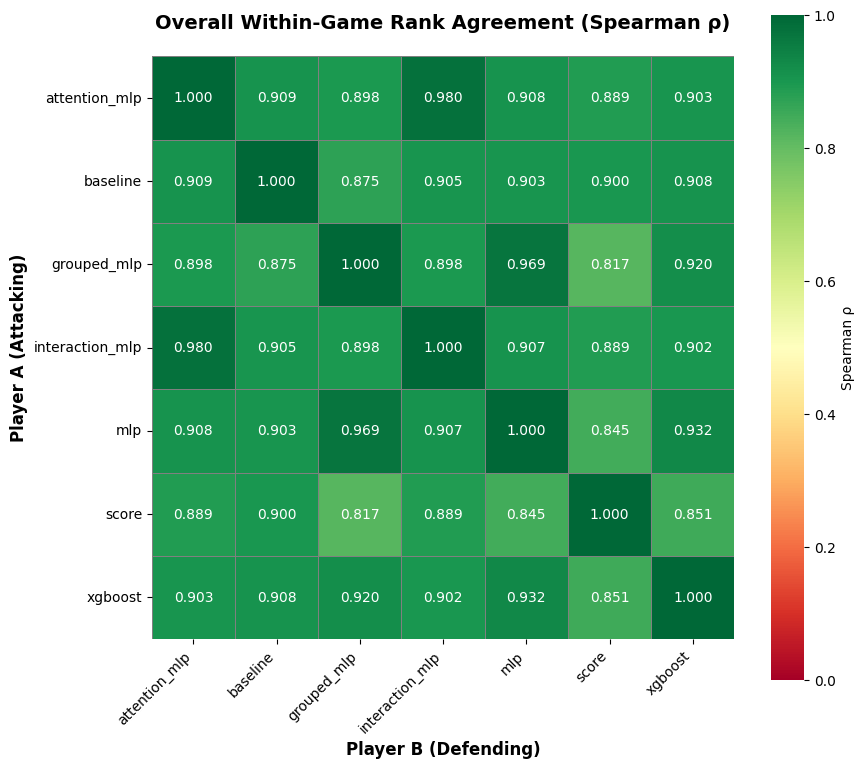

In [3]:
import sys
sys.path.insert(0, "..")
from plot_utilities import plot_matchup_heatmap
import seaborn as sns

# Compute ranks per (game_id, turn) for each model
pred_cols = [f"pred_{name}" for name in model_names]

rank_df = merged[["game_id", "turn"]].copy()
for col in pred_cols:
    rank_df[col + "_rank"] = merged.groupby(["game_id", "turn"])[col].rank(ascending=False)

rank_cols = [f"{col}_rank" for col in pred_cols]

# --- 2b-i: Overall Spearman rank correlation heatmap (all turns) ---
corr_matrix = pd.DataFrame(np.ones((len(model_names), len(model_names))),
                           index=model_names, columns=model_names)
for i, j in combinations(range(len(model_names)), 2):
    r1 = rank_df[rank_cols[i]].values
    r2 = rank_df[rank_cols[j]].values
    mask = ~(np.isnan(r1) | np.isnan(r2))
    corr, _ = spearmanr(r1[mask], r2[mask])
    corr_matrix.iloc[i, j] = corr
    corr_matrix.iloc[j, i] = corr

fig, ax = plot_matchup_heatmap(
    corr_matrix,
    title="Overall Within-Game Rank Agreement (Spearman ρ)",
    figsize=(9, 8),
    cmap="RdYlGn",
    as_percentage=False,
    vmin=0, vmax=1, center=0.5,
    annot_format=".3f",
    cbar_label="Spearman ρ",
)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

### Rank Agreement by Turn Progress
How does model agreement evolve over the course of a game?  
Rows are model pairs; columns are turn-progress bins.

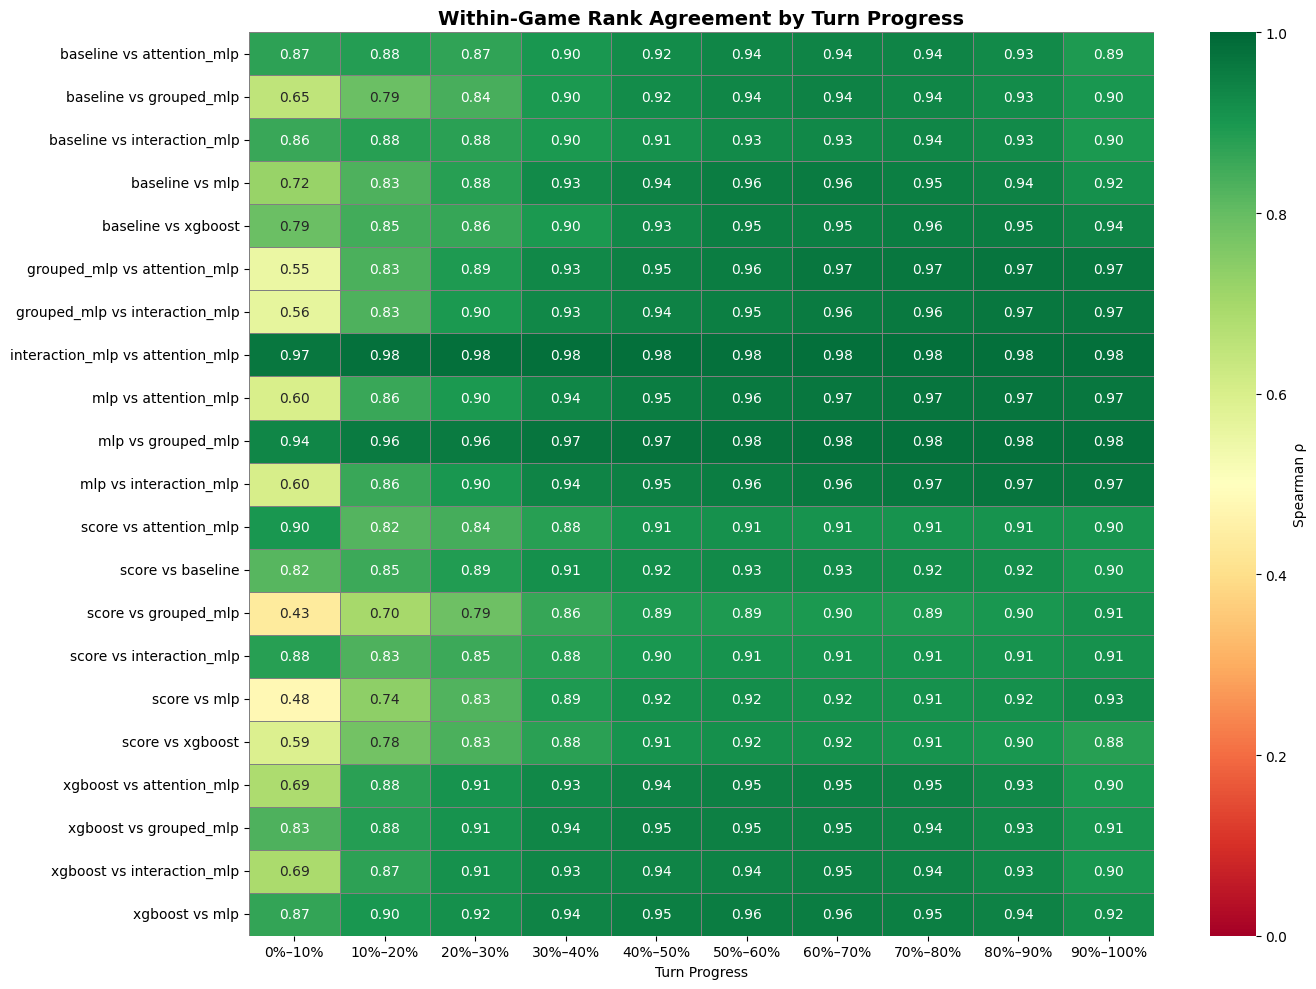

In [4]:
# Get turn_progress (one value per game/turn)
tp = models[model_names[0]][["game_id", "turn", "turn_progress"]].drop_duplicates()
rank_df2 = rank_df.merge(tp, on=["game_id", "turn"], how="left")

# Bin by turn progress
progress_bins = np.arange(0, 1.1, 0.1)
progress_labels = [f"{progress_bins[i]:.0%}–{progress_bins[i+1]:.0%}" for i in range(len(progress_bins) - 1)]
rank_df2["progress_bin"] = pd.cut(rank_df2["turn_progress"], bins=progress_bins, labels=progress_labels, right=False)

# Compute pairwise Spearman correlation per progress bin
pairs_idx = list(combinations(range(len(model_names)), 2))
pair_labels = [f"{model_names[i]} vs {model_names[j]}" for i, j in pairs_idx]

corr_results = []
for bin_label, bin_group in rank_df2.groupby("progress_bin", observed=True):
    for (i, j), pair_name in zip(pairs_idx, pair_labels):
        r1 = bin_group[rank_cols[i]].values
        r2 = bin_group[rank_cols[j]].values
        mask = ~(np.isnan(r1) | np.isnan(r2))
        if mask.sum() > 10:
            corr, _ = spearmanr(r1[mask], r2[mask])
        else:
            corr = np.nan
        corr_results.append({"pair": pair_name, "bin": bin_label, "spearman": corr})

corr_df = pd.DataFrame(corr_results)
heatmap_data = corr_df.pivot(index="pair", columns="bin", values="spearman")

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".2f", cmap="RdYlGn",
    vmin=0, vmax=1, center=0.5,
    linewidths=0.5, linecolor="gray",
    cbar_kws={"label": "Spearman ρ"},
    ax=ax,
)
ax.set_title("Within-Game Rank Agreement by Turn Progress", fontsize=14, fontweight="bold")
ax.set_xlabel("Turn Progress")
ax.set_ylabel("")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()